In [1]:
import meld

In [2]:
from sotip import *
import numpy as np
import scanpy as sc


In [3]:
def random_spatial(num_cells,x_range,y_range):
# num_cells = adata_sub.shape[0]
# x_range = (0,100)
# y_range = (0,100)

    x_random = np.random.random(size=(num_cells,))*(x_range[1]-x_range[0])+x_range[0]
    y_random = np.random.random(size=(num_cells,))*(y_range[1]-y_range[0])+y_range[0]
    spatial_mat = np.vstack([x_random,y_random]).transpose()
    return  spatial_mat


In [15]:
adata = sc.read_h5ad('simulation_data/simulation1.h5ad')

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)



# ploting

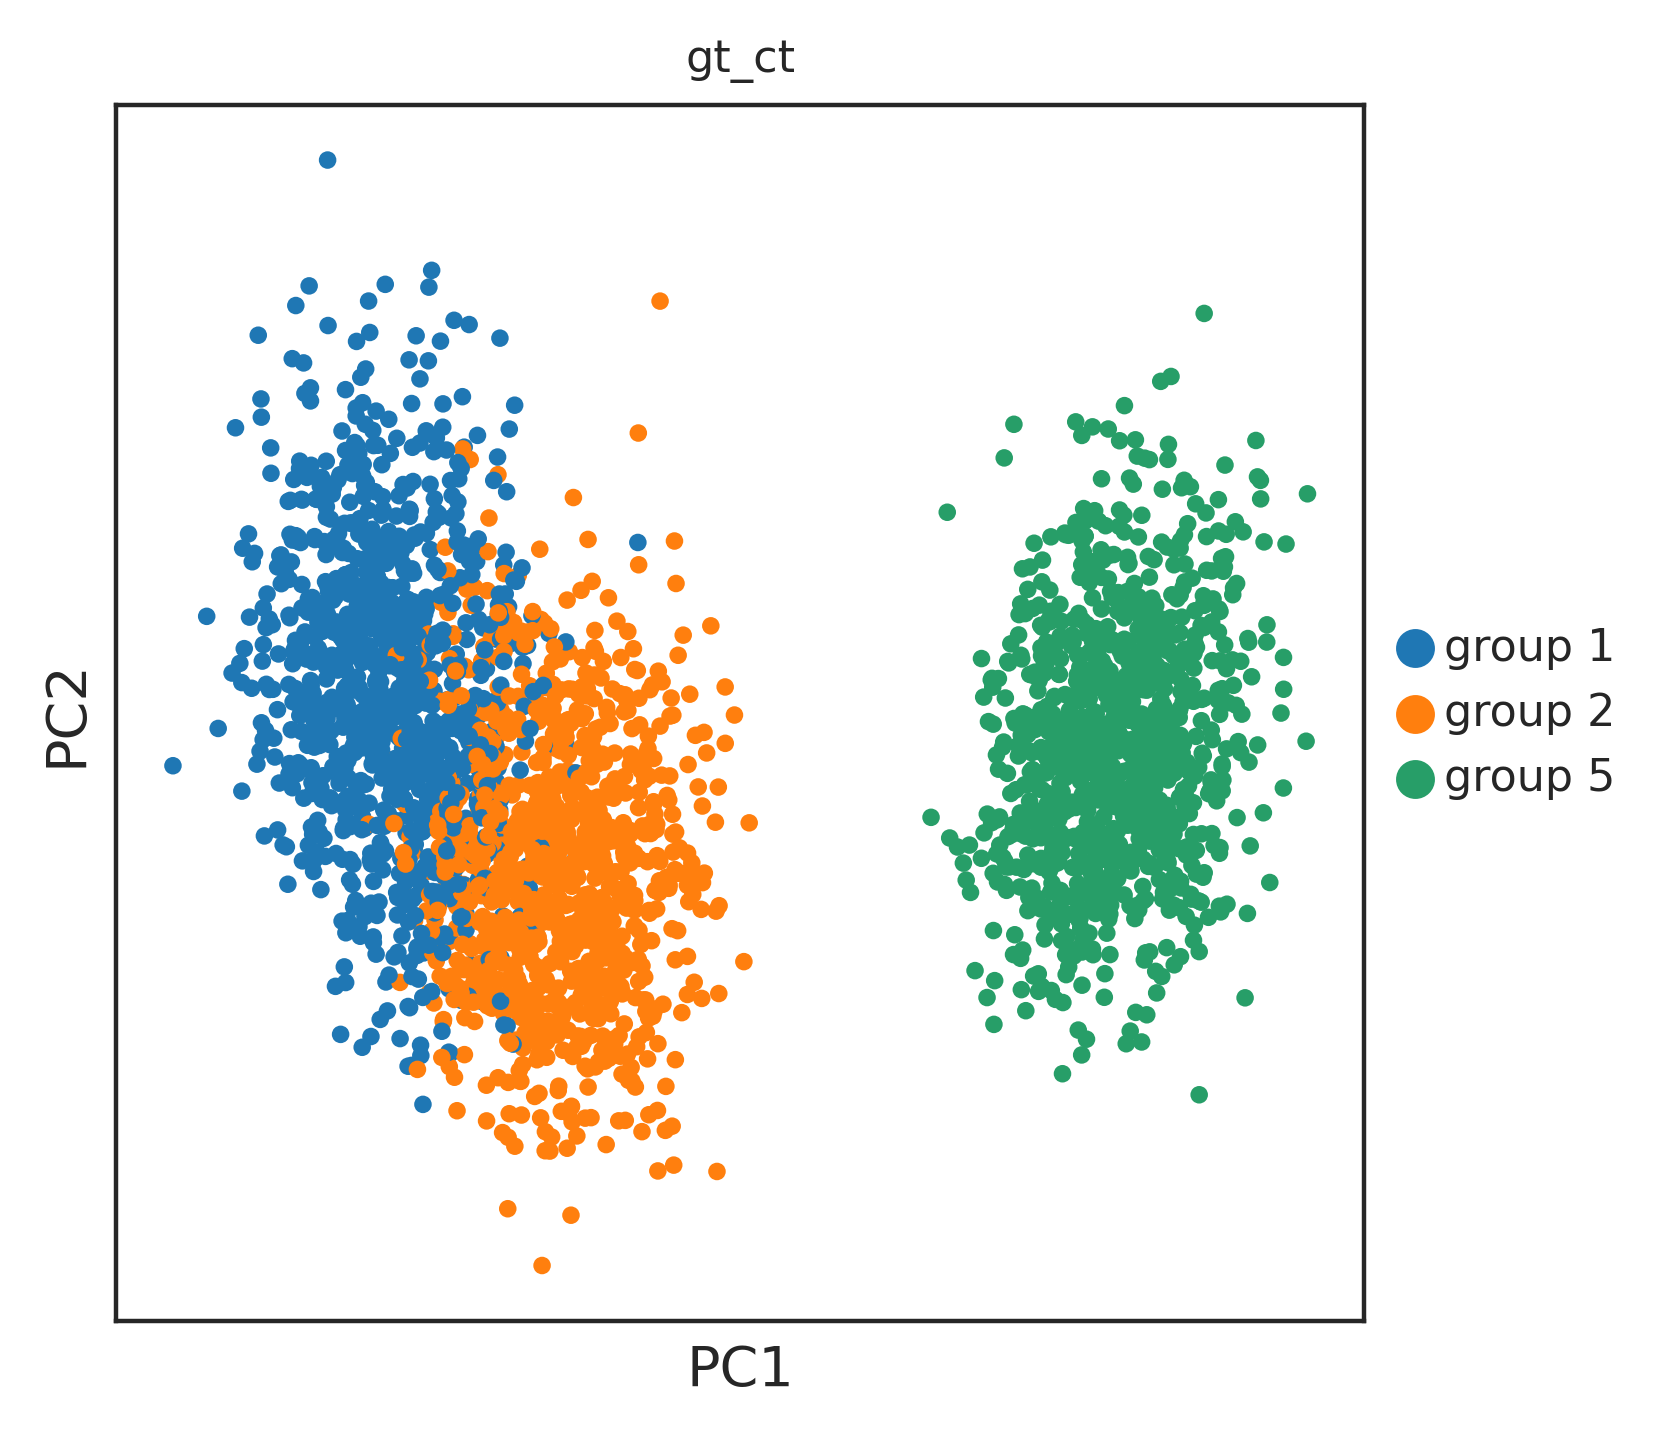

In [17]:
sc.pl.pca(adata,color='gt_ct')

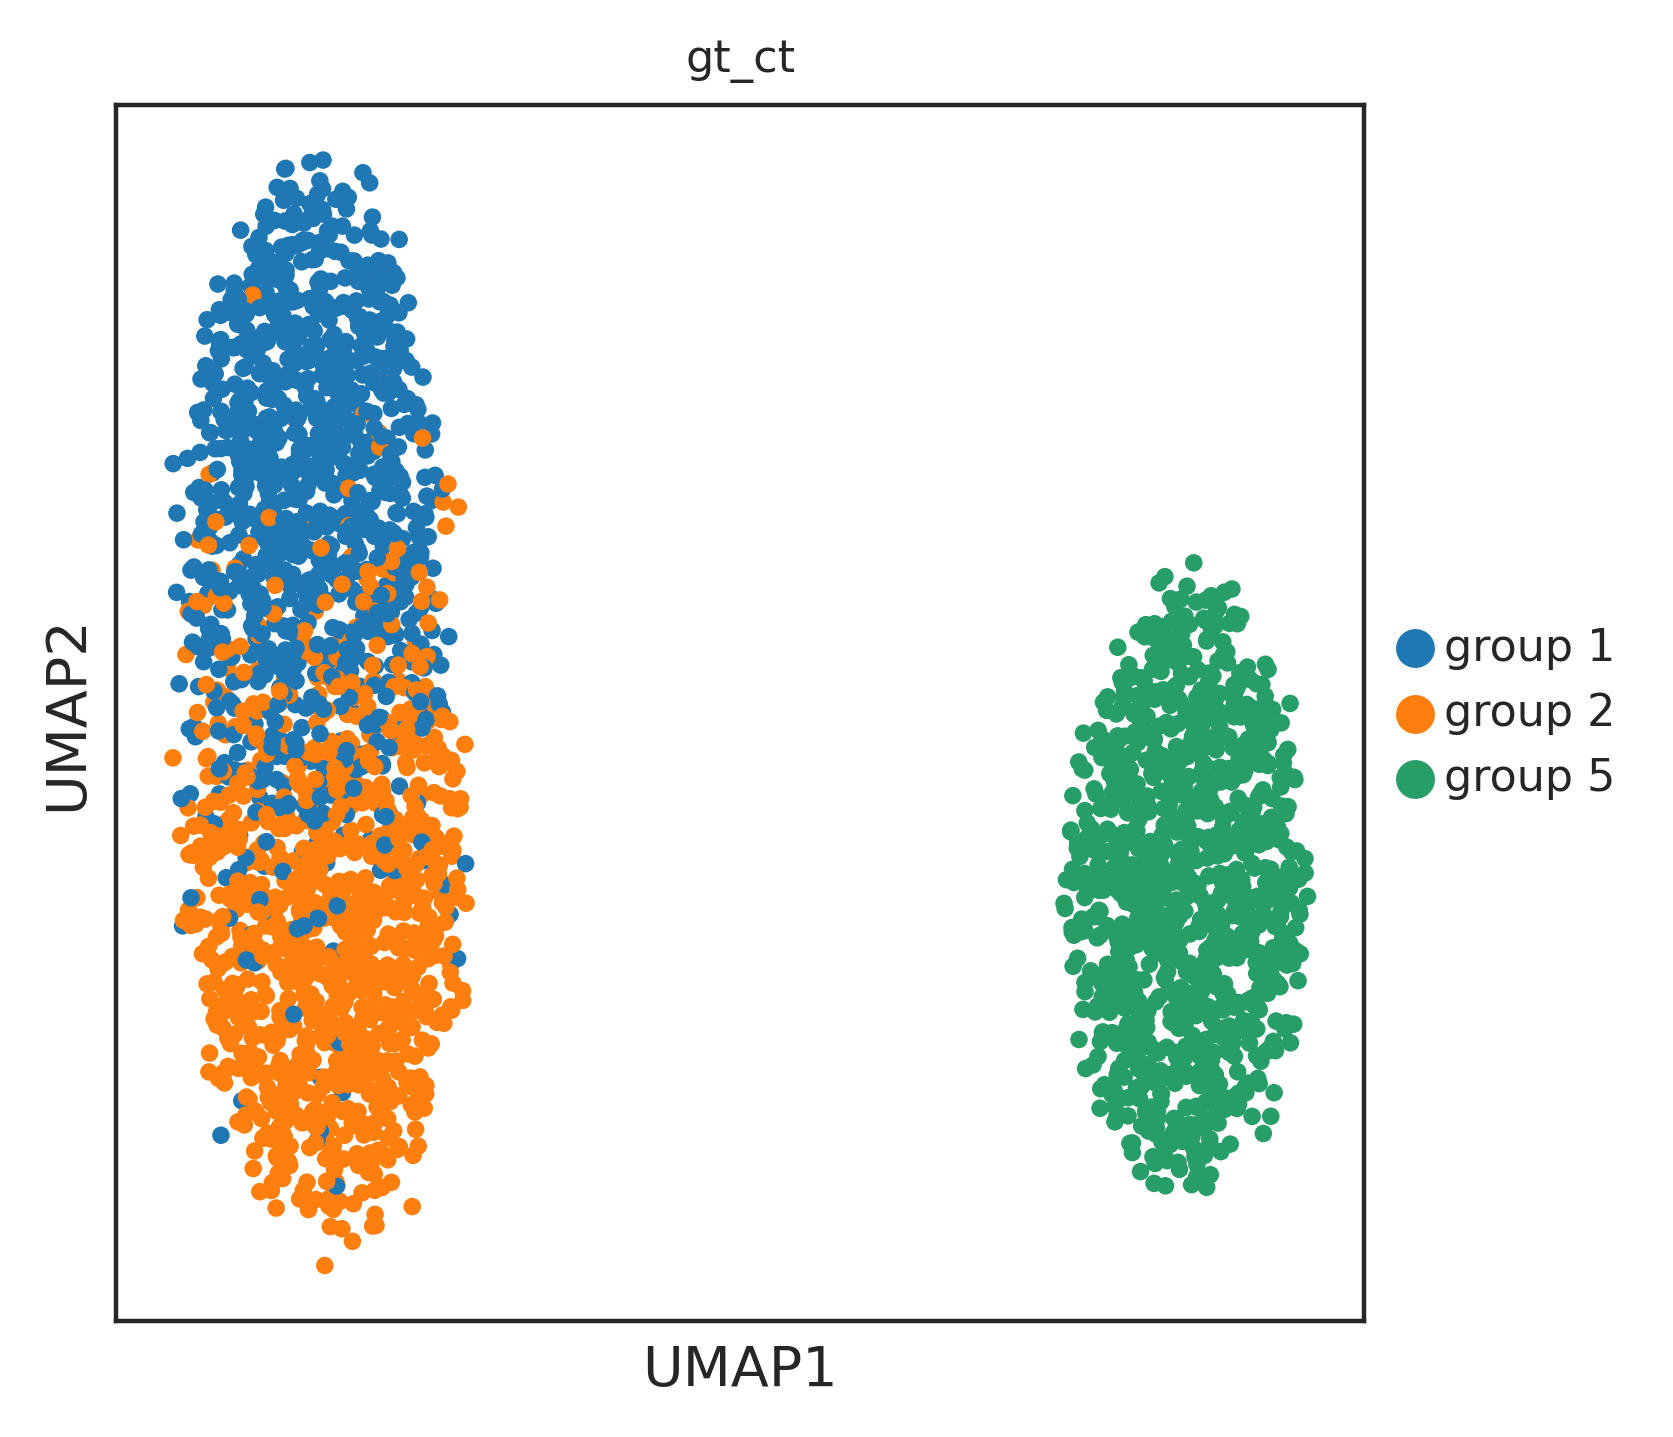

In [18]:
sc.pl.umap(adata,color='gt_ct')

In [28]:
def get_adata_by_order(order,adata_source):
    adata = adata_source.copy()
    order_ct = [f'group {i}' for i in order]
    spatial_mat = np.zeros(shape=(adata.shape[0],2))
    for i in range(len(order_ct)):
        ct = order_ct[i]
        cur_ct_id = np.where(adata.obs['gt_ct']==ct)[0]
        cur_num_cells = len(cur_ct_id)
        cur_spatial = random_spatial(cur_num_cells,[30*(i),30*(i+1)],[0,90])
        spatial_mat[cur_ct_id] = cur_spatial
        # region_array[cur_ct_id] =  
    adata.obsm['spatial'] = spatial_mat
    return adata

In [29]:
adata1 = get_adata_by_order([1,2,5],adata)
adata2 = get_adata_by_order([1,5,2],adata)


In [30]:
adata1

AnnData object with n_obs × n_vars = 3009 × 1000
    obs: 'gt_ct'
    uns: 'pca', 'neighbors', 'umap', 'gt_ct_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

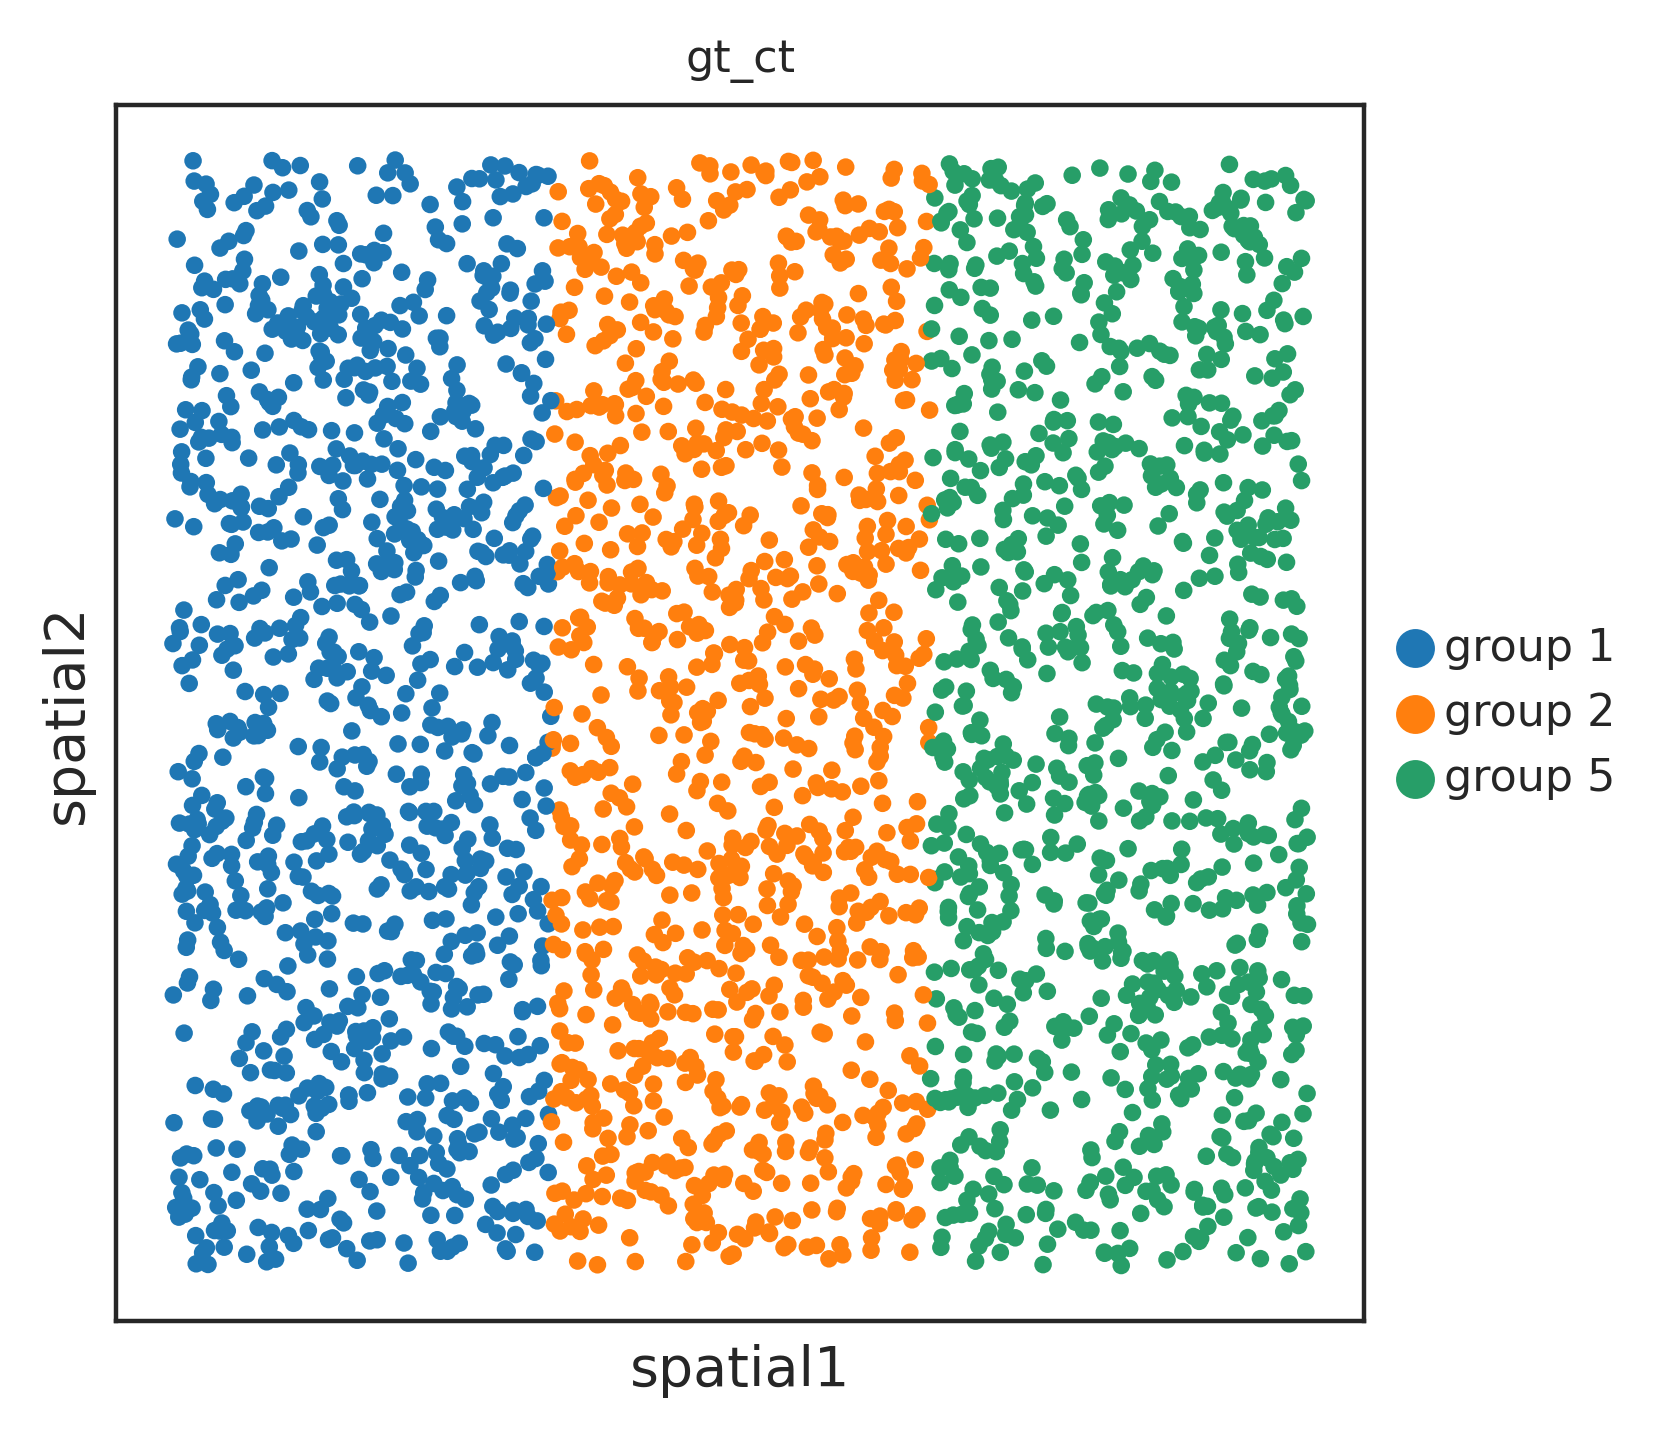

In [31]:
sc.pl.embedding(adata1,basis='spatial',color='gt_ct')

In [33]:
adata = adata1.concatenate([adata2])

In [34]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)



# heter

## ME

knn search time cost 0.007508516311645508 s
0 MEs,time cost 1.9073486328125e-06 s, 3009 MEs, 5.739212036132812e-06s left
1000 MEs,time cost 0.1415877342224121 s, 2009 MEs, 0.2844497580528259s left
2000 MEs,time cost 0.14189910888671875 s, 1009 MEs, 0.14317620086669922s left
3000 MEs,time cost 0.1373124122619629 s, 9 MEs, 0.001235811710357666s left
knn search time cost 0.007152080535888672 s
0 MEs,time cost 1.9073486328125e-06 s, 3009 MEs, 5.739212036132812e-06s left
1000 MEs,time cost 0.1389296054840088 s, 2009 MEs, 0.27910957741737363s left
2000 MEs,time cost 0.13657212257385254 s, 1009 MEs, 0.13780127167701722s left
3000 MEs,time cost 0.14153337478637695 s, 9 MEs, 0.0012738003730773926s left


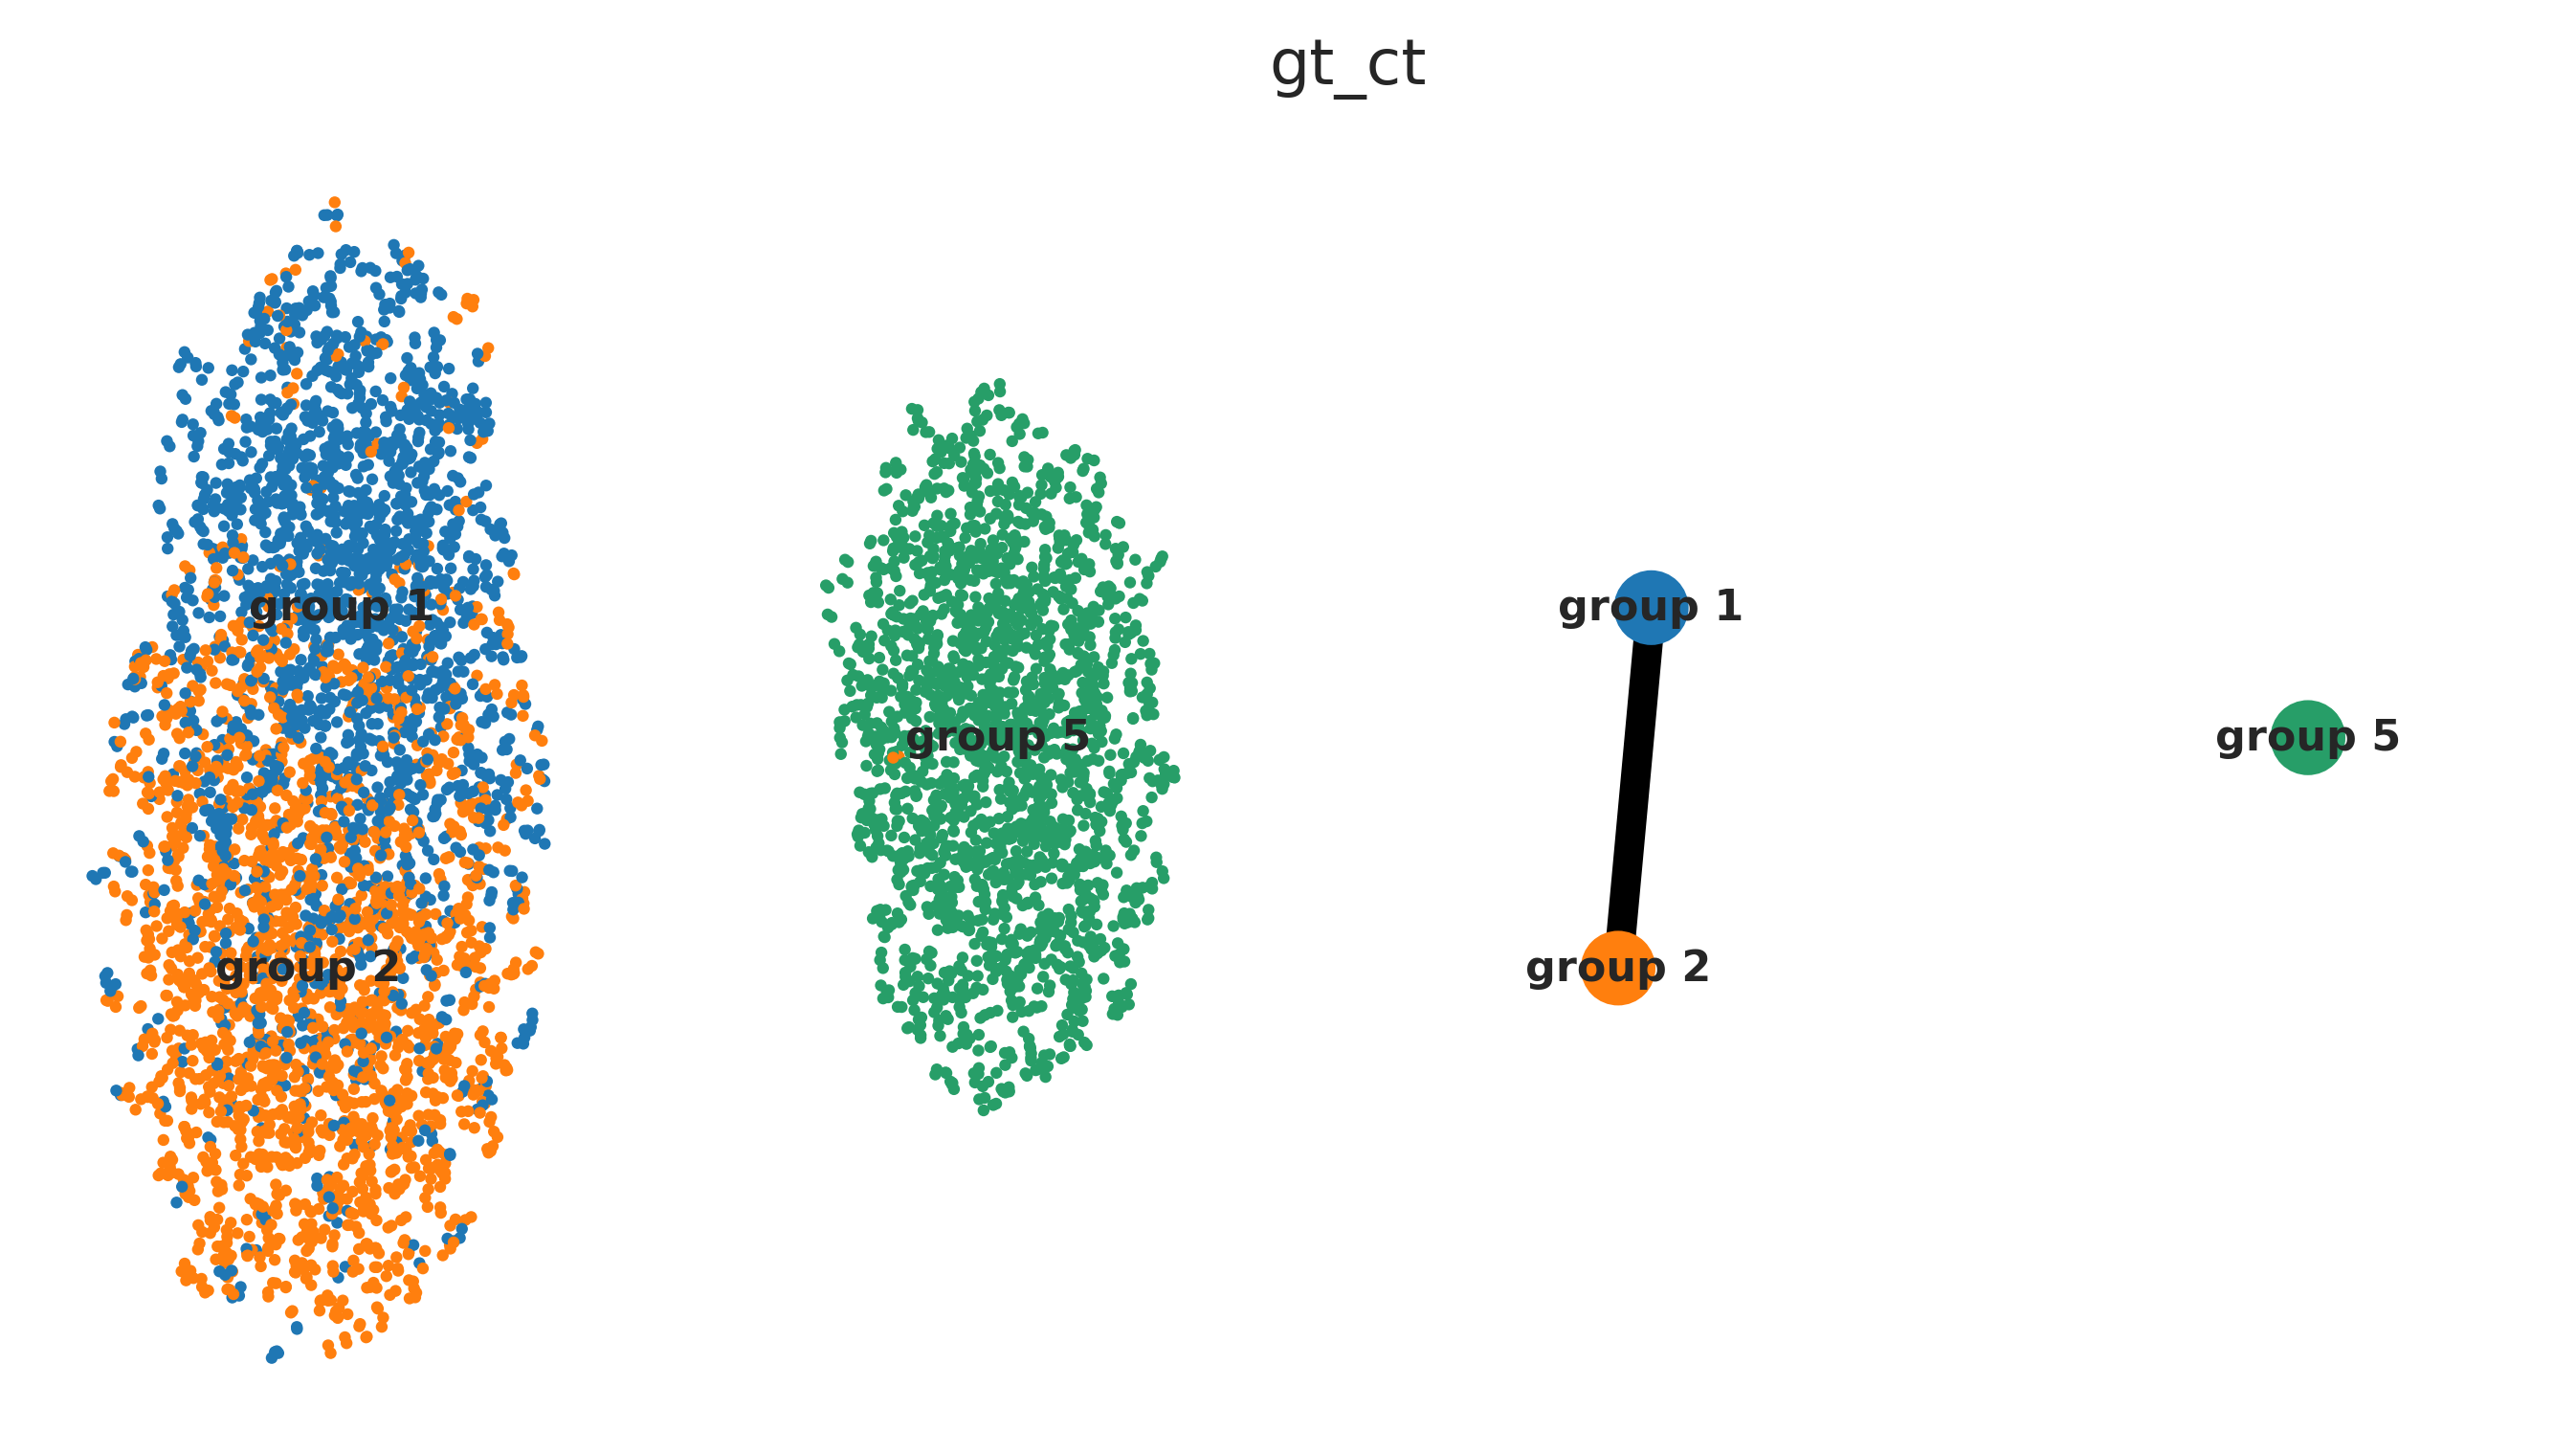

In [35]:
knn = 10
spatial_var='spatial'
cls_key='gt_ct'
ME_var_names_np_unique = np.unique(adata.obs[cls_key]) 
MED_multi(adata,use_cls=cls_key,nn=knn,copy=False,ME_var_names_np_unique=ME_var_names_np_unique,spatial_var=spatial_var,batch_obs='batch')
# MED(adata,use_cls=cls_key,nn=knn,copy=False,ME_var_names_np_unique=ME_var_names_np_unique,spatial_var=spatial_var) 
sc.tl.paga(adata,groups=cls_key)
sc.pl.paga_compare(adata,basis='X_umap')    


## sotip

In [37]:
gd_method = 'paga_guided_umap'
gd = get_ground_distance(adata,method=gd_method,cls_key=cls_key,embed_key=None,connect_threshold=0.5)  



In [38]:
heter_key = 'ME_heter_{0}_{1}'.format(cls_key,gd_method)
cal_ME_heterogeneity(adata,copy=False,key_added=heter_key) 

In [108]:
adata

AnnData object with n_obs × n_vars = 6018 × 1000
    obs: 'gt_ct', 'batch', 'ME_heter_gt_ct_paga_guided_umap'
    uns: 'pca', 'neighbors', 'umap', 'paga', 'gt_ct_sizes', 'gt_ct_colors', 'GD'
    obsm: 'X_pca', 'X_umap', 'spatial', 'ME'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

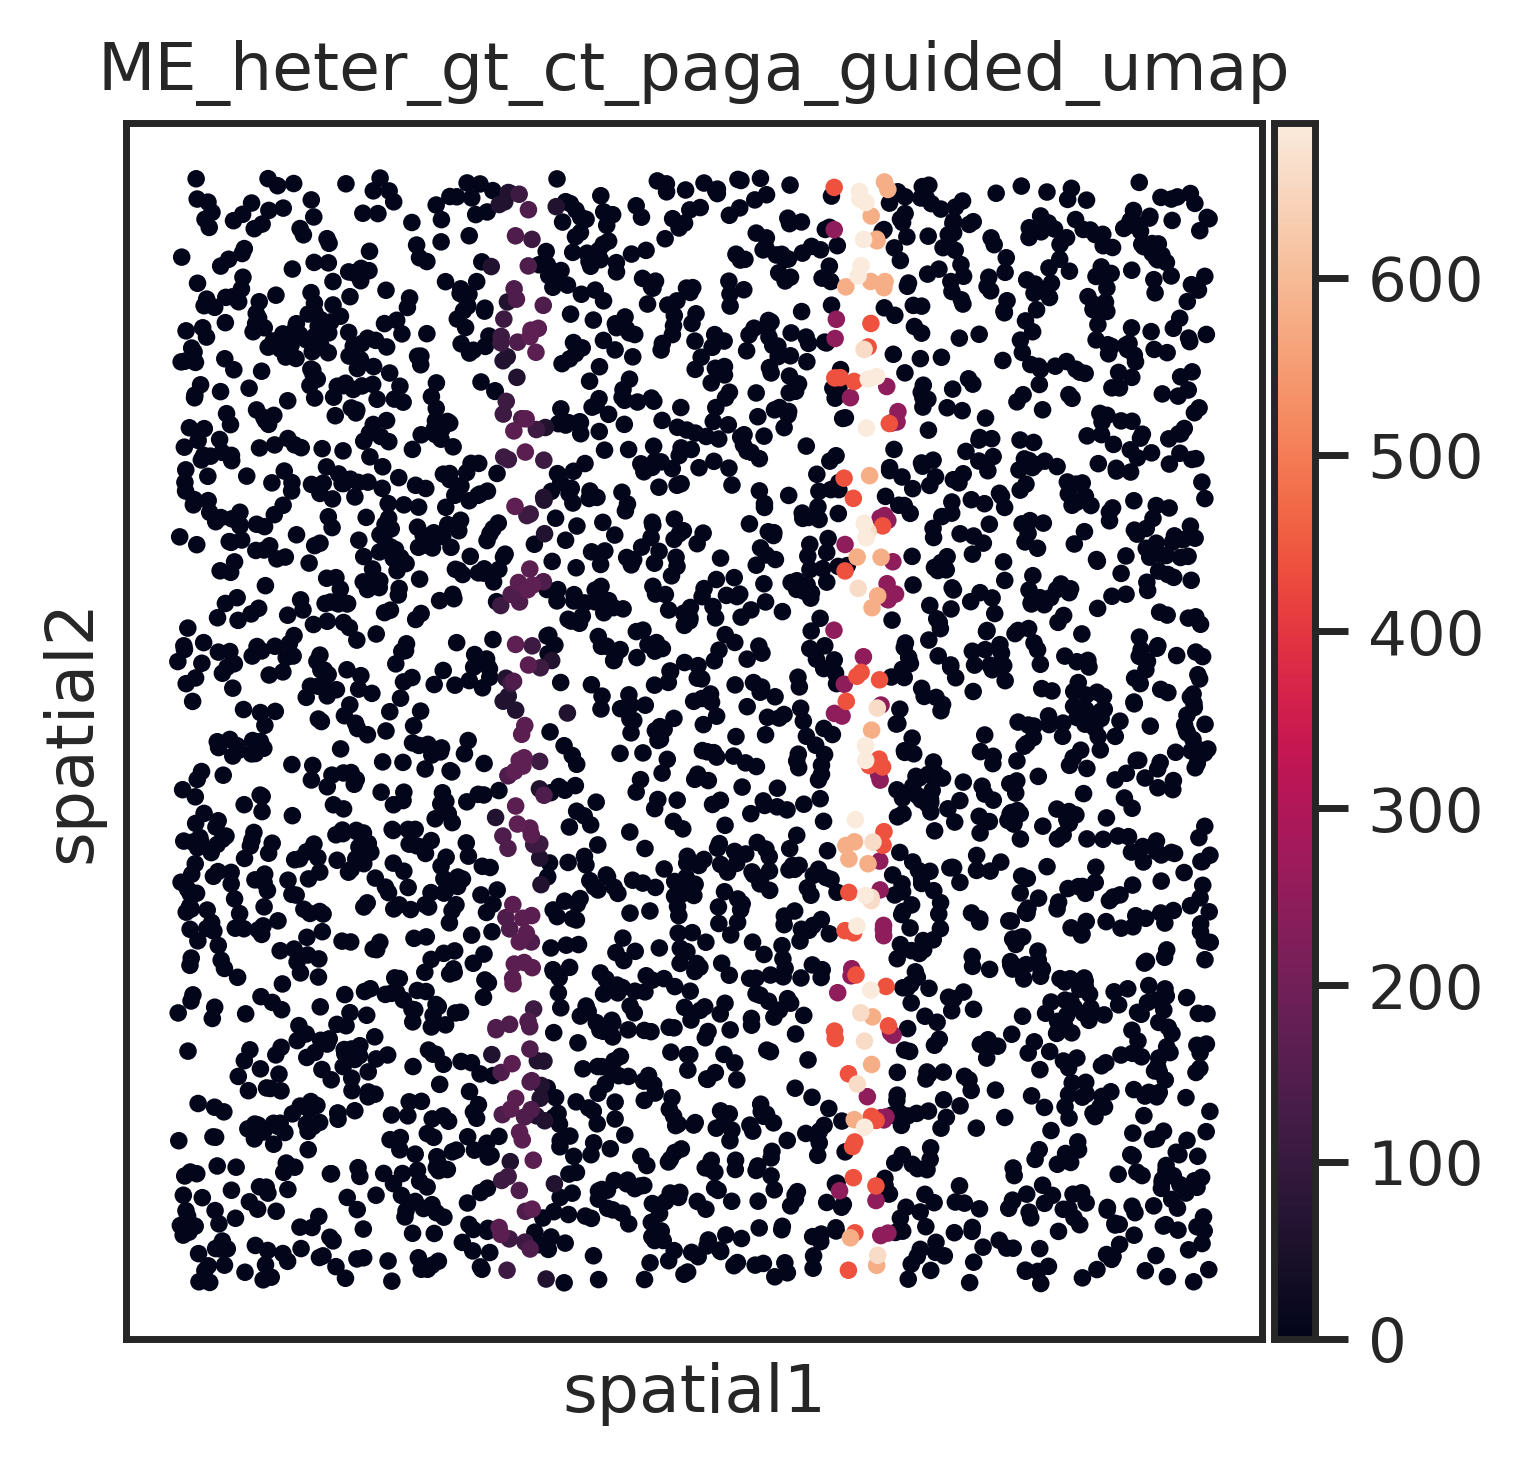

In [142]:
sc.pl.embedding(adata[adata.obs['batch']=='0'],basis='spatial',color=['ME_heter_gt_ct_paga_guided_umap'])

Text(0.5, 1.0, '125_heter')

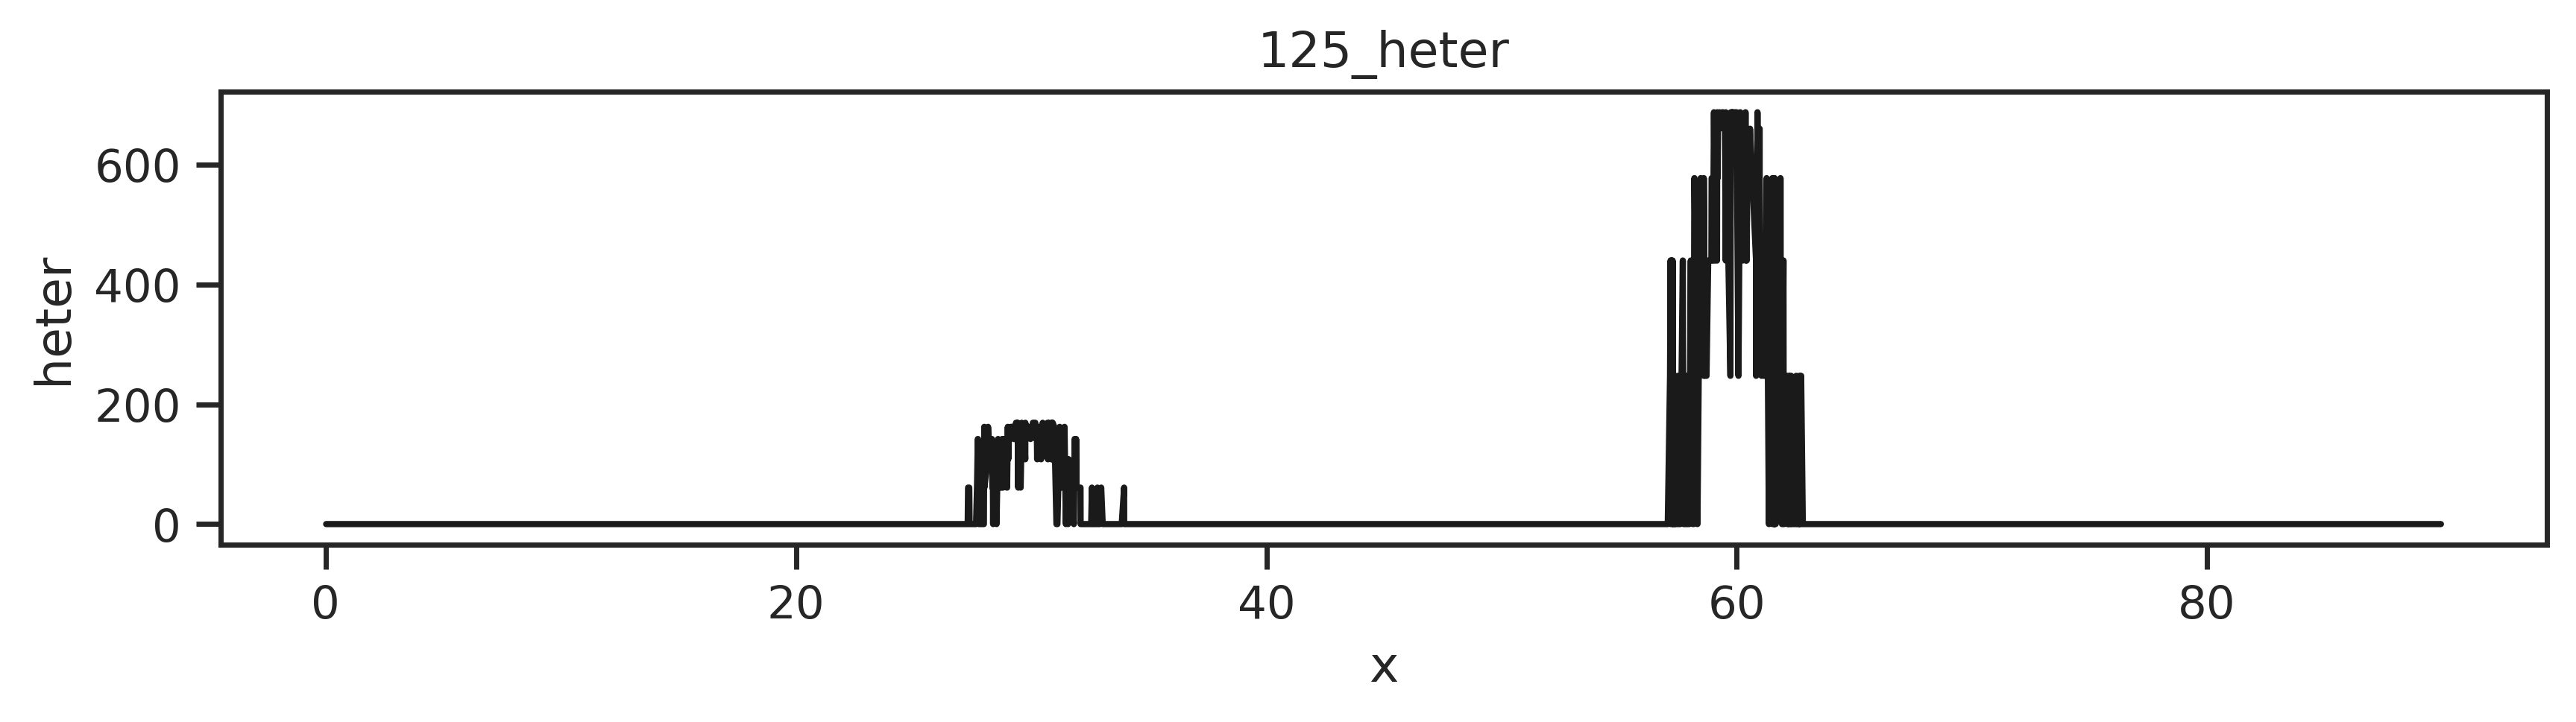

In [126]:
adata_use = adata[adata.obs['batch']=='0']

spatial_mat = adata_use.obsm['spatial']
heter_array = adata_use.obs['ME_heter_gt_ct_paga_guided_umap']
pd_dict = {
    'x':spatial_mat[:,0],
    'y':spatial_mat[:,1],
    'heter':heter_array
}
pd_df = pd.DataFrame(pd_dict)
fig,ax = plt.subplots(1,1,figsize=(10,2))
ax = sns.lineplot(x="x", y="heter",
             # hue="method", 
             # data=pd_df[pd_df['method']!='sum'],
             data=pd_df,
             color='k'
                  
                  # c='k'
            )
plt.title('125_heter')
# ax.get_legend().remove()

## IGD

In [173]:
gd_method = 'uniform'
cls_key = 'gt_ct'
gd = get_ground_distance(adata,method=gd_method,cls_key=cls_key,embed_key=None,connect_threshold=0.1)  


In [174]:
heter_key = 'ME_heter_{0}_{1}'.format(cls_key,gd_method)

cal_ME_heterogeneity(adata,copy=False,key_added=heter_key) 

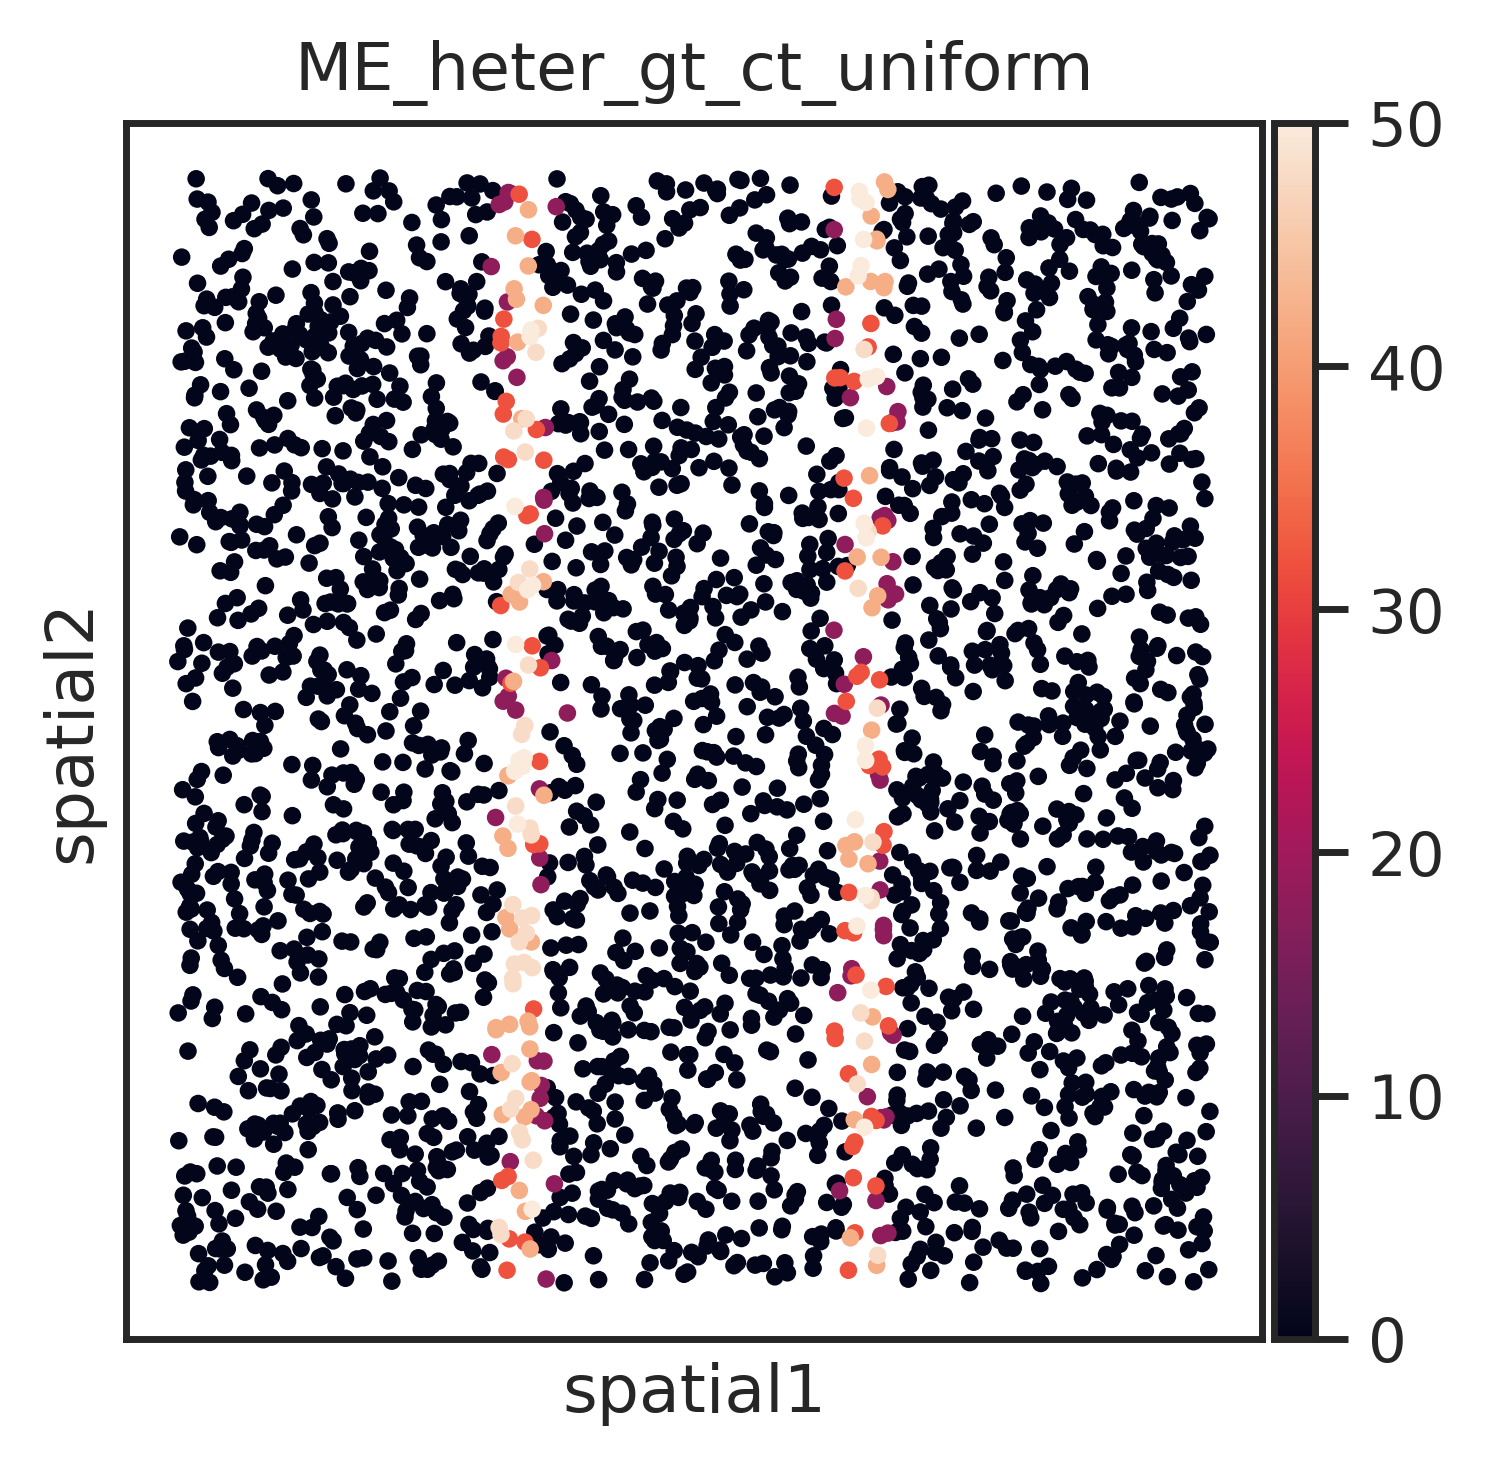

In [175]:
sc.pl.embedding(adata[adata.obs['batch']=='0'],basis='spatial',color=[heter_key])

Text(0.5, 1.0, '152_heter_log')

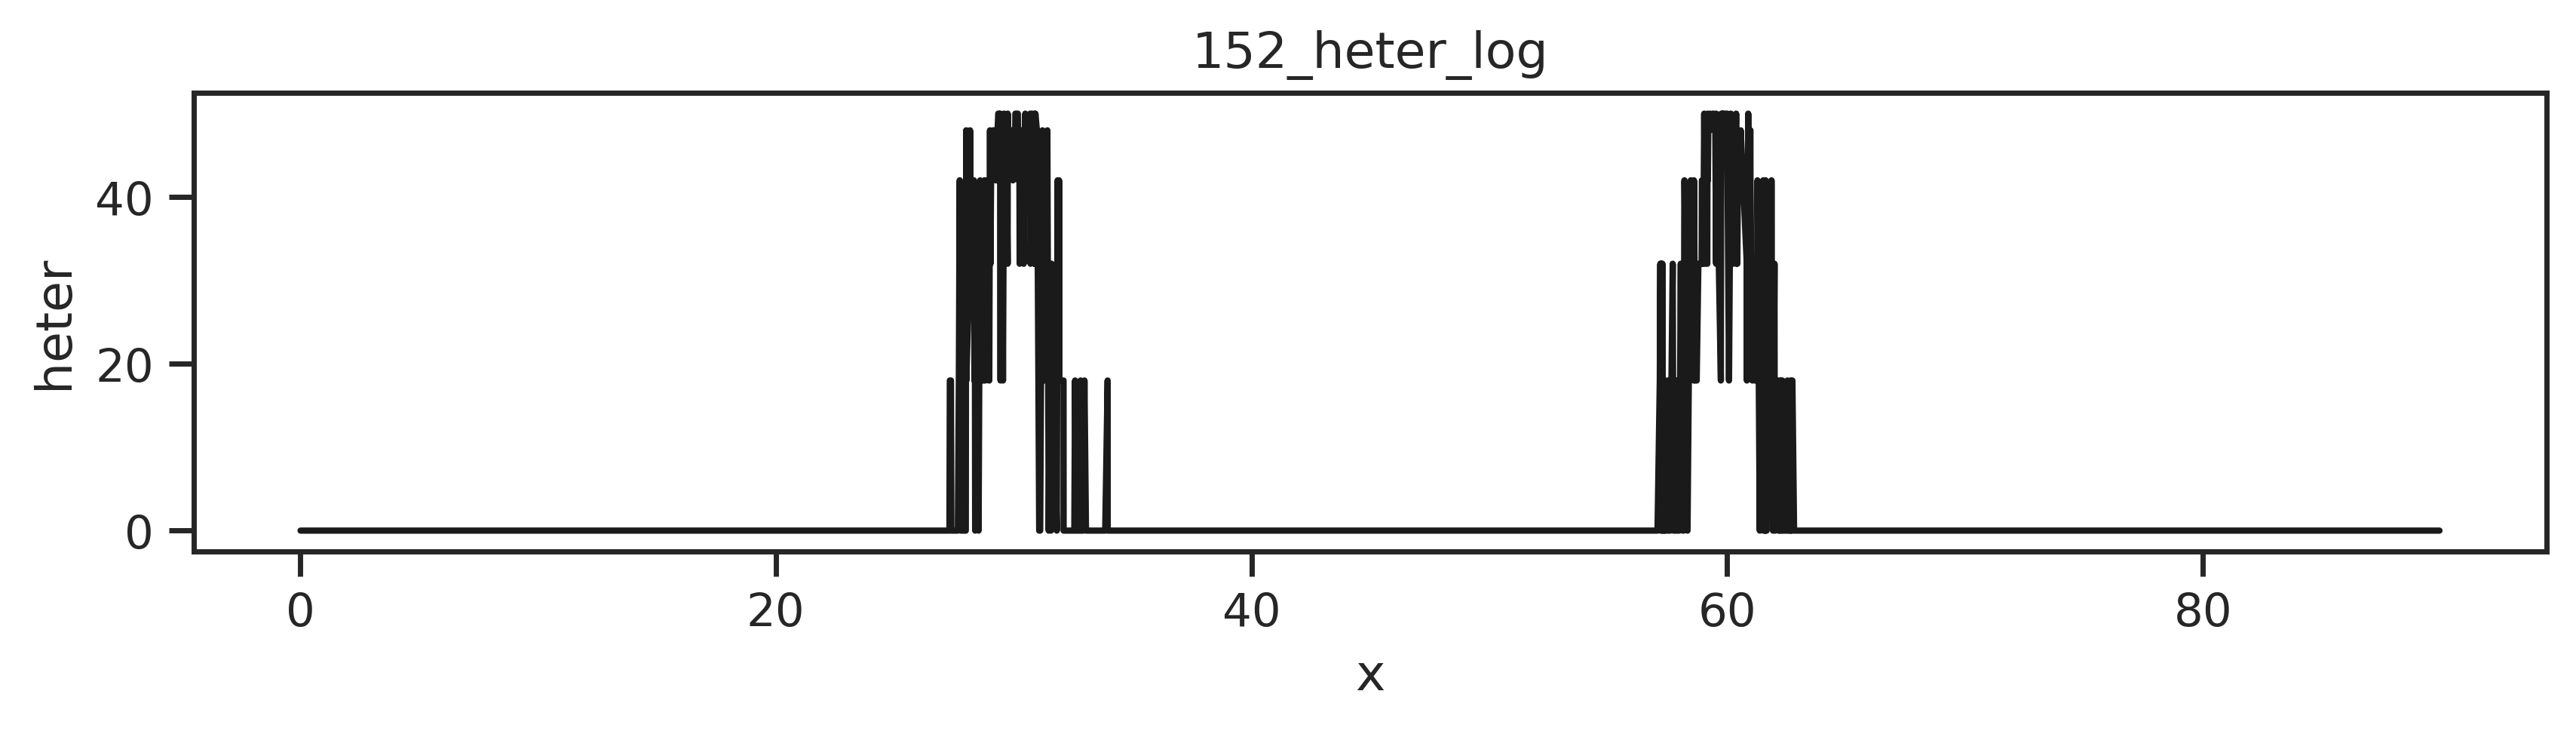

In [176]:
adata_use = adata[adata.obs['batch']=='0']

spatial_mat = adata_use.obsm['spatial']
# heter_array = adata_use.obs['ME_heter_gt_ct_paga_guided_umap']
heter_array = adata_use.obs[heter_key]

pd_dict = {
    'x':spatial_mat[:,0],
    'y':spatial_mat[:,1],
    'heter':heter_array
}
pd_df = pd.DataFrame(pd_dict)
fig,ax = plt.subplots(1,1,figsize=(10,2))
ax = sns.lineplot(x="x", y="heter",
             # hue="method", 
             # data=pd_df[pd_df['method']!='sum'],
             data=pd_df,
             color='k'
                  
                  # c='k'
            )
# ax.get_legend().remove()
plt.title('152_heter_log')


## NUCC

In [134]:
def heter_count_cls(adata):
    from toolz import compose
    cls_count = np.apply_along_axis(compose(len, np.unique), 1, adata.obsm['ME'])
    adata.obs['heter_nct'] = cls_count

In [135]:
heter_count_cls(adata)

In [136]:
adata

AnnData object with n_obs × n_vars = 6018 × 1000
    obs: 'gt_ct', 'batch', 'ME_heter_gt_ct_paga_guided_umap', 'heter_log', 'heter_nct'
    uns: 'pca', 'neighbors', 'umap', 'paga', 'gt_ct_sizes', 'gt_ct_colors', 'GD'
    obsm: 'X_pca', 'X_umap', 'spatial', 'ME'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

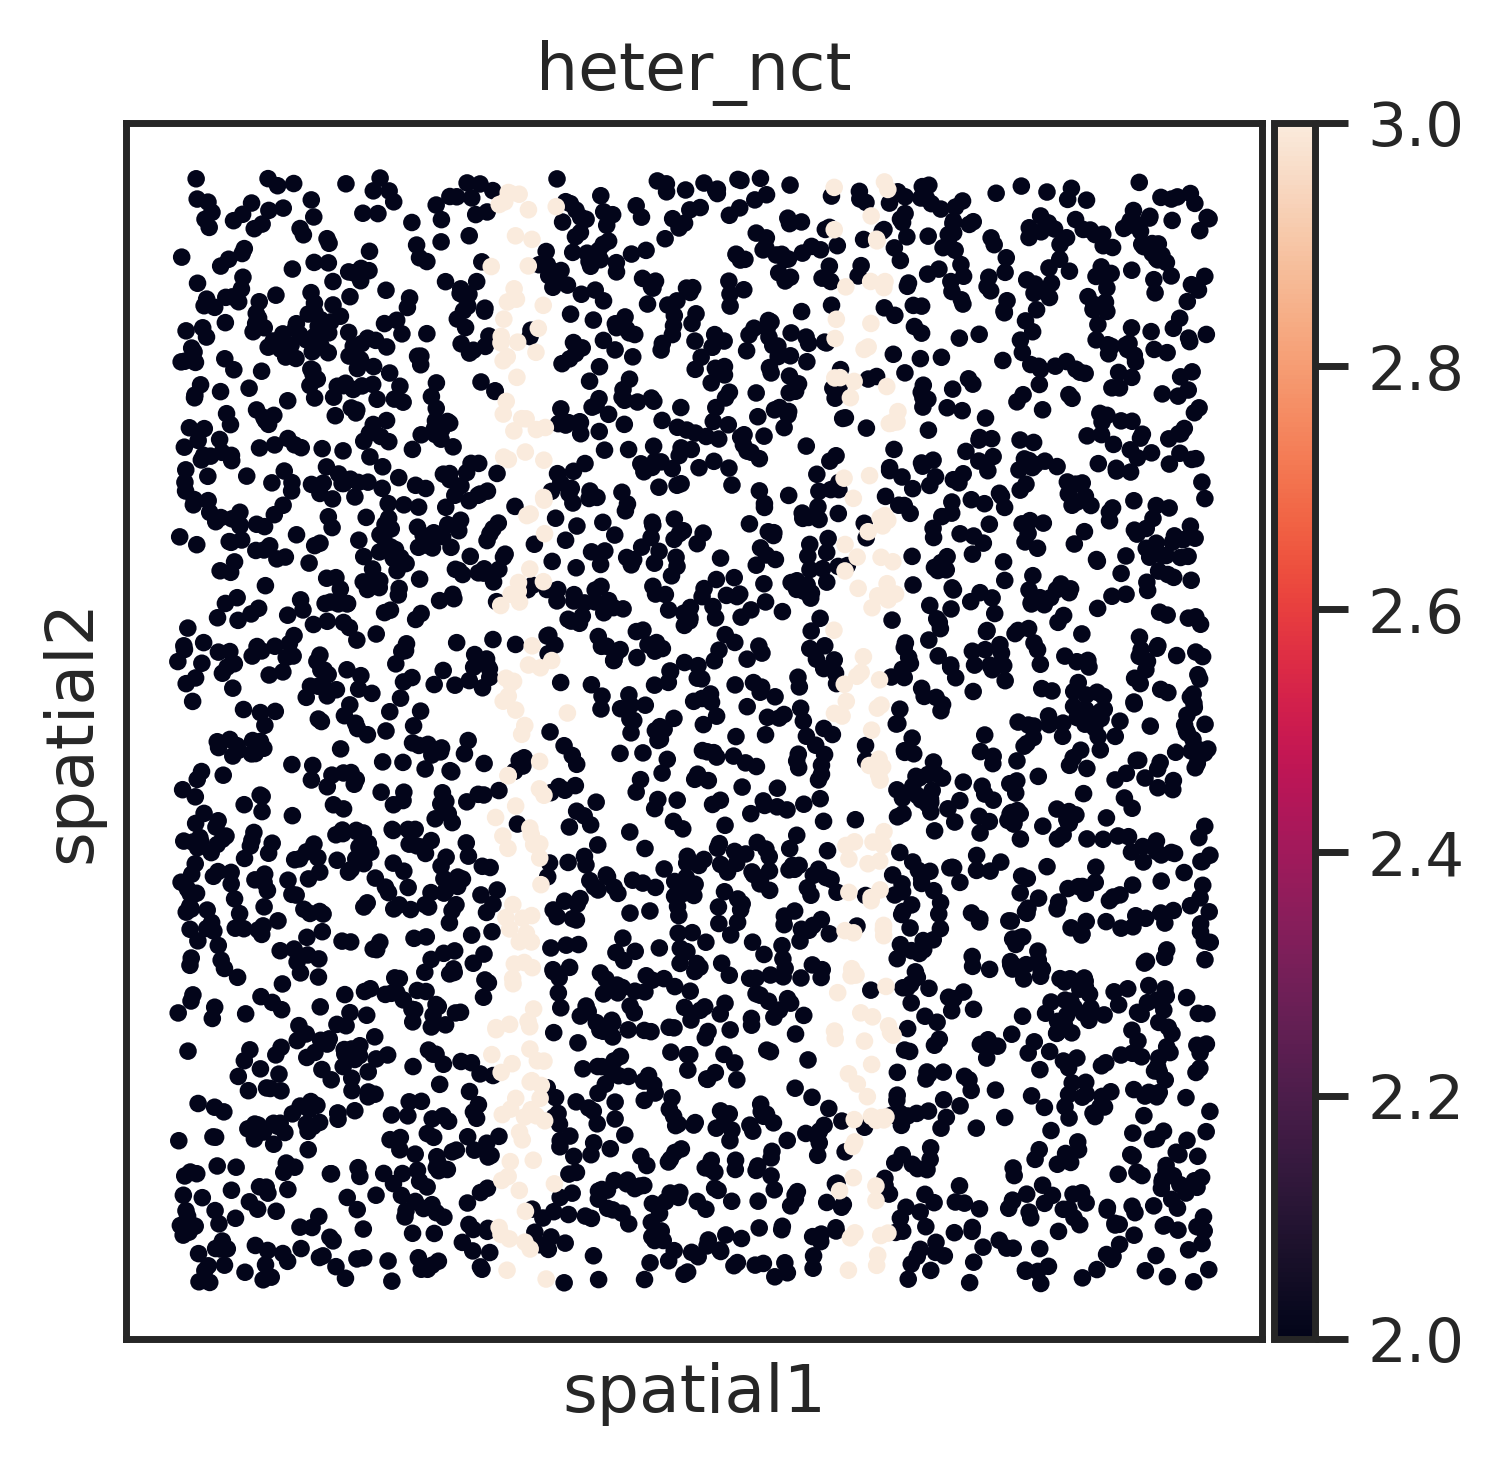

In [138]:
sc.pl.embedding(adata[adata.obs['batch']=='0'],basis='spatial',color=['heter_nct'])

Text(0.5, 1.0, '125_heter')

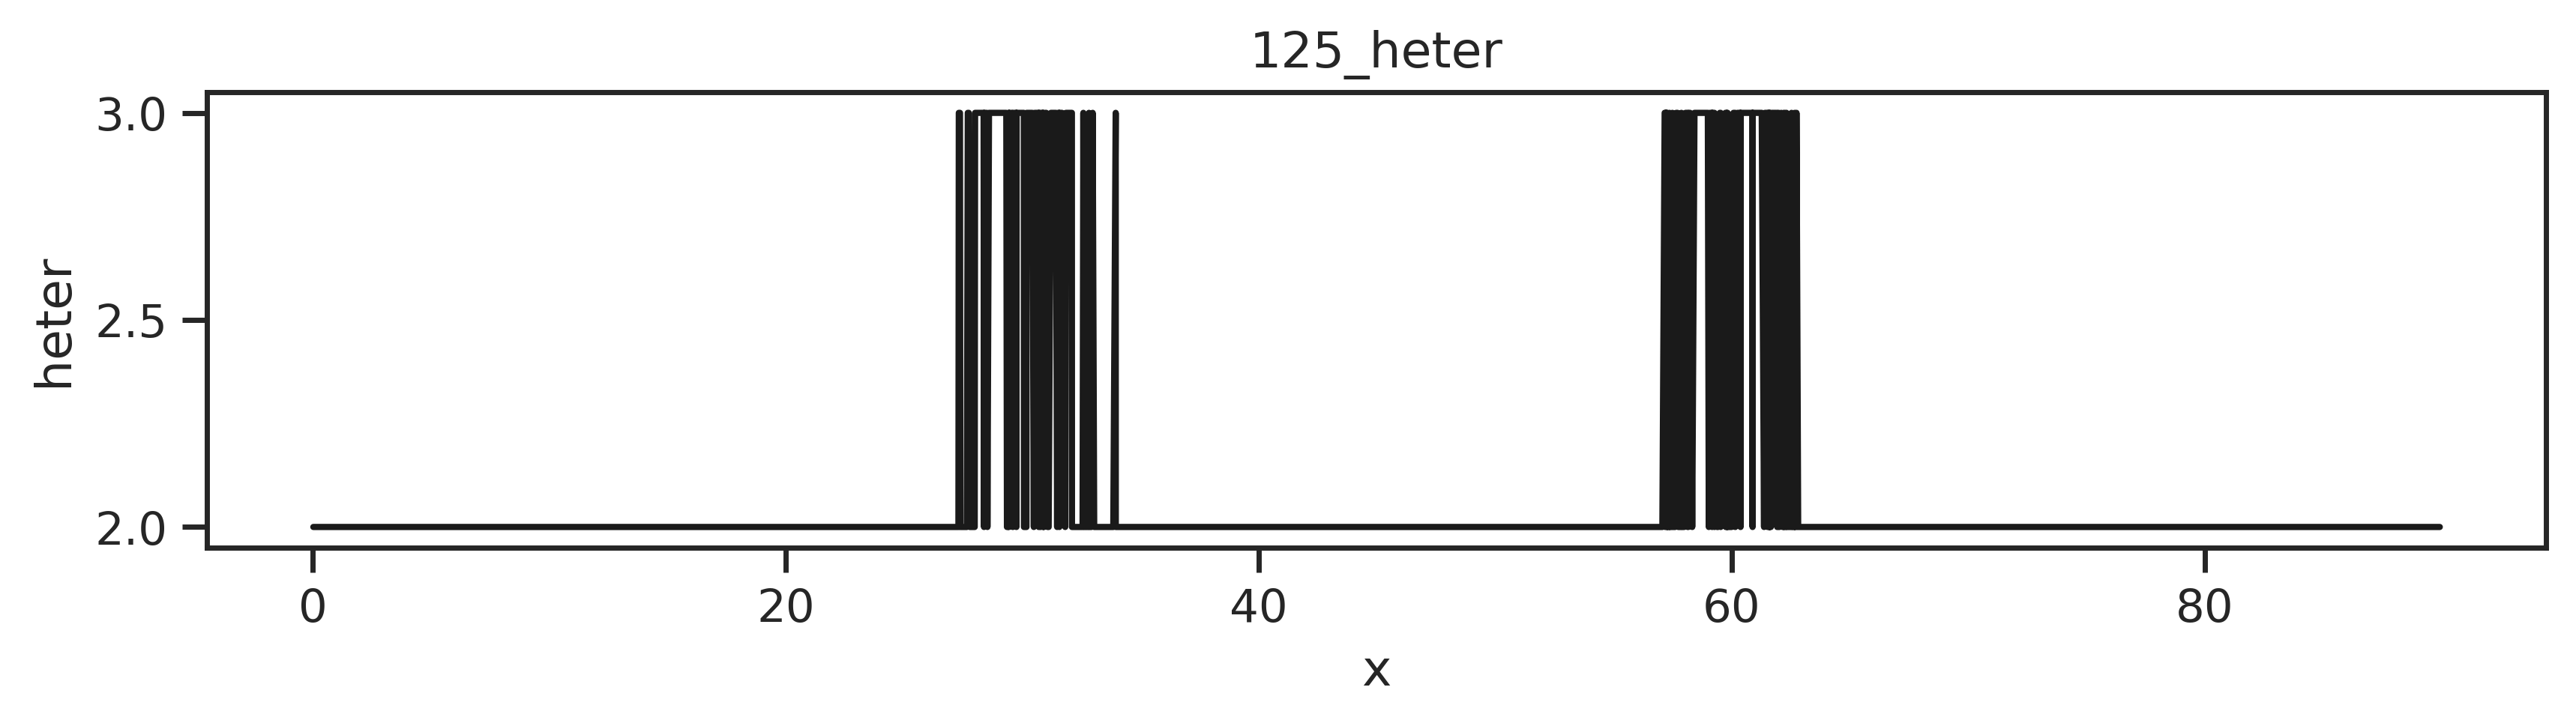

In [140]:
adata_use = adata[adata.obs['batch']=='0']

spatial_mat = adata_use.obsm['spatial']
heter_array = adata_use.obs['heter_nct']

pd_dict = {
    'x':spatial_mat[:,0],
    'y':spatial_mat[:,1],
    'heter':heter_array
}
pd_df = pd.DataFrame(pd_dict)
fig,ax = plt.subplots(1,1,figsize=(10,2))
ax = sns.lineplot(x="x", y="heter",
             # hue="method", 
             # data=pd_df[pd_df['method']!='sum'],
             data=pd_df,
             color='k'
                  
                  # c='k'
            )
plt.title('125_heter')

# ax.get_legend().remove()